In [1]:
#import bayesopt
import gpbayesopt as bayesopt
import GaussianProcess as GP

import matplotlib.pyplot as plt
import seaborn as sns

from jax.config import config; config.update("jax_enable_x64", True)
from functools import partial
import jax.numpy as np

/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


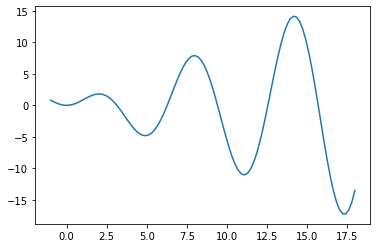

In [2]:
def f(x):
    return x*np.sin(x)

plt.plot(np.linspace(-1,18,100),f(np.linspace(-1,18,100)))

# BO

In [3]:
def PI(mu,sigma,**kwargs):
    import scipy as scp
    vmax = kwargs.get('vmax')
    vmix = kwargs.get('vmin')
    it = kwargs.get('it')
    xi = 1.*np.sqrt(np.log(it+1.)/(it+1.))
    Z = (mu-vmax-xi)/sigma
    return scp.stats.norm.cdf(Z)

In [4]:
# %%timeit
BO = bayesopt.BayesOpt(f=f,
                       initial_input=np.array([0.]),
                       kernel=bayesopt.kernel.MaternKernel(),
                       acq=PI,
                       acq_optim=bayesopt.acquisition_optimizer.Acquisition_Grid_Optimizer(bounds=[0,18],step=0.1),
                       maximize=True,
                       )
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s, param:[13.6], value:11.684600682048357, current best param:[14.2], current best_value:14.171978468572336]


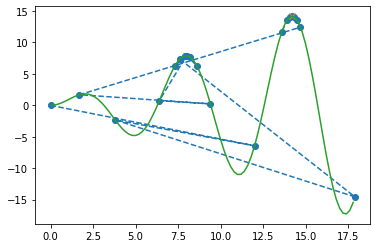

In [5]:
X = np.arange(0,18,0.2)

plt.plot(BO.param_history,BO.value_history,'o--')
plt.plot(BO.best_params,BO.best_value,'x')
plt.plot(X,f(X))

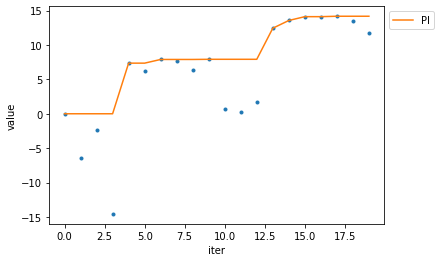

In [6]:
bayesopt.plot_history(BO)

In [7]:
def view_acqfunc(i=1):
    X_obs,Y_obs = BO.param_history[:i+1],BO.value_history[:i+1]
    gpr = GP.GPR(X_obs,Y_obs,alpha=BO.alpha,kernel=BO.kernel)
    X = np.linspace(0,18,100)
    Y_mu,Y_std = gpr.posterior_predictive(X,return_std=True)
    acq_val = BO.acq(Y_mu,Y_std,vmax=max(BO.value_history[:i+1]),vmin=0,it=i)
    
    # 95% confidence interval
    uncertainty = 1.96 * Y_std
    
    plt.figure(figsize=[8,8])
    plt.subplot(211)
    plt.plot(X,Y_mu)
    plt.fill_between(X.ravel(), (Y_mu + uncertainty).ravel(), (Y_mu - uncertainty).ravel(), alpha=0.1)
    plt.plot(X_obs,Y_obs,'x')

    plt.subplot(212)
    plt.plot(X,acq_val)

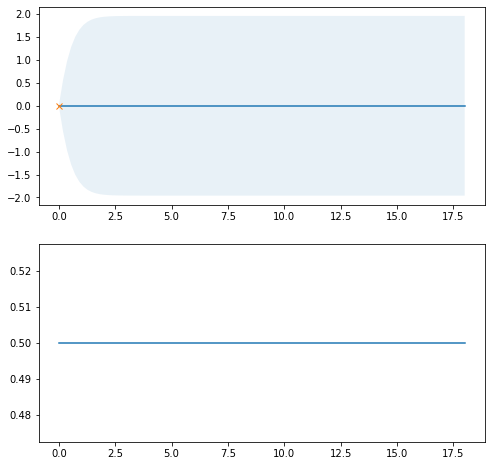

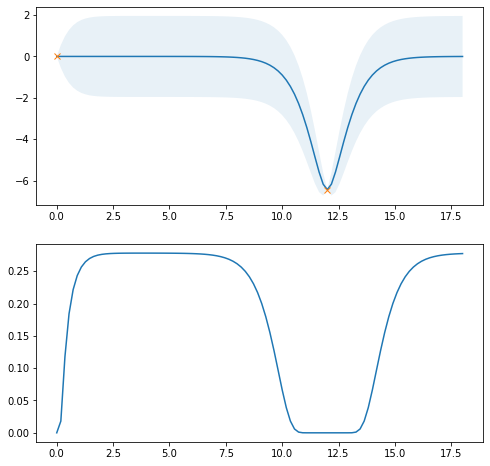

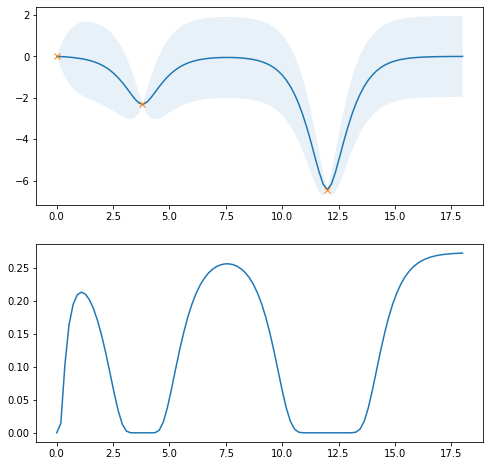

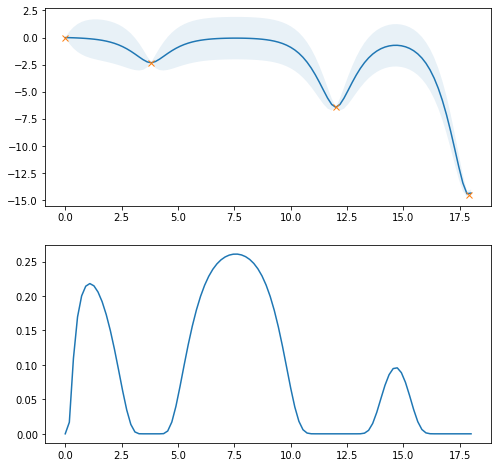

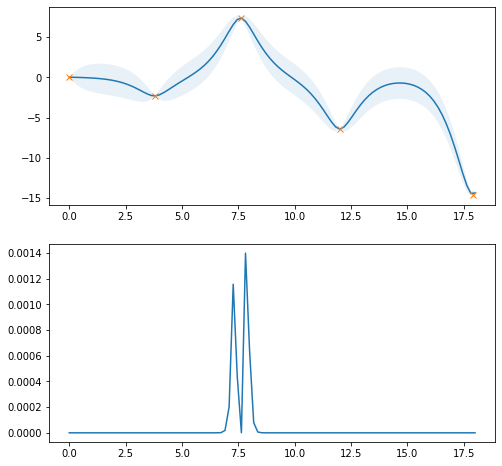

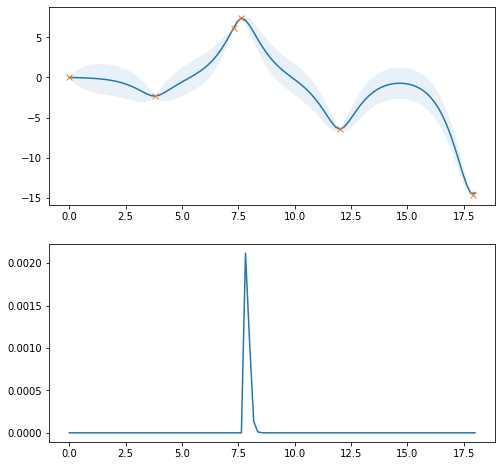

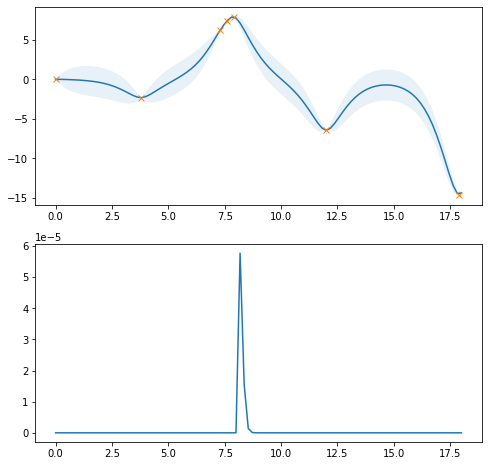

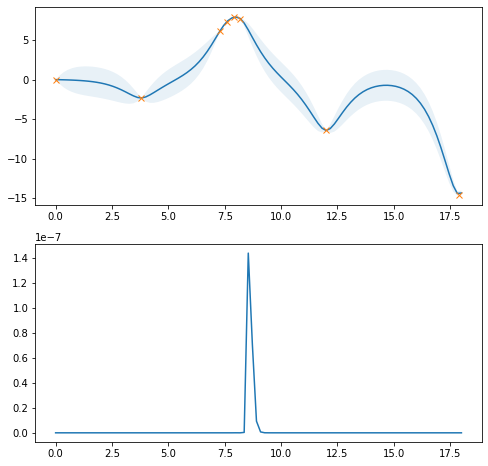

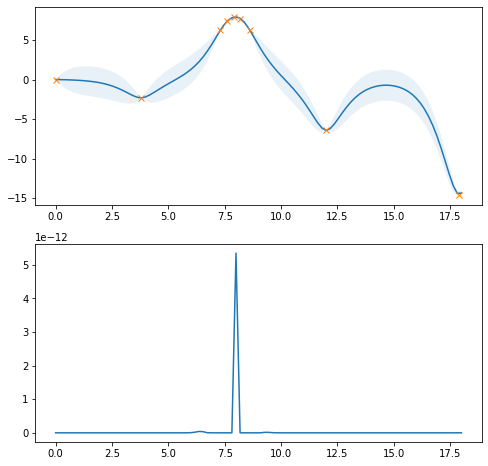

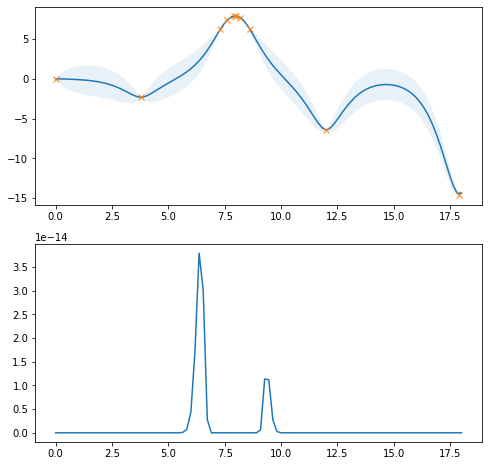

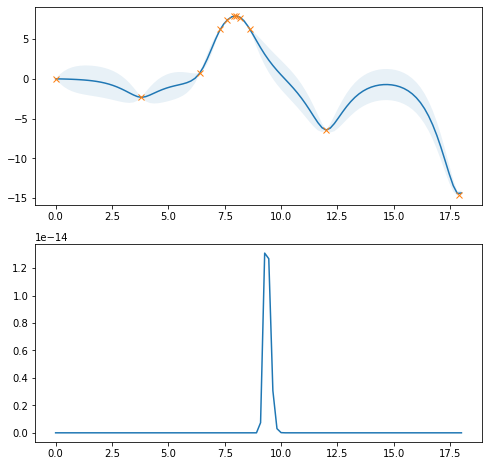

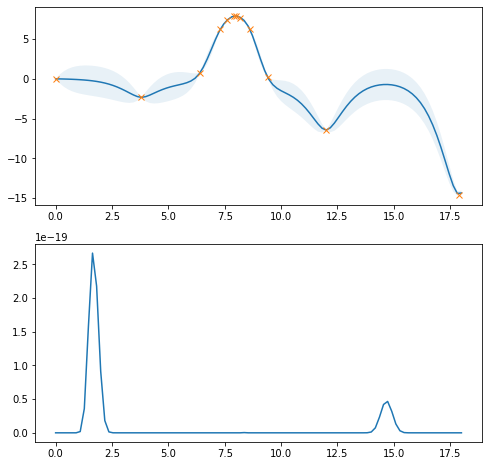

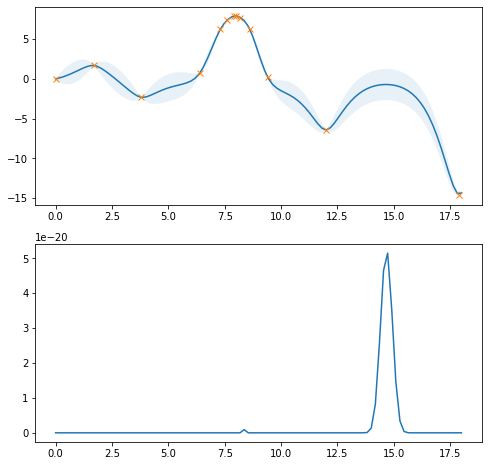

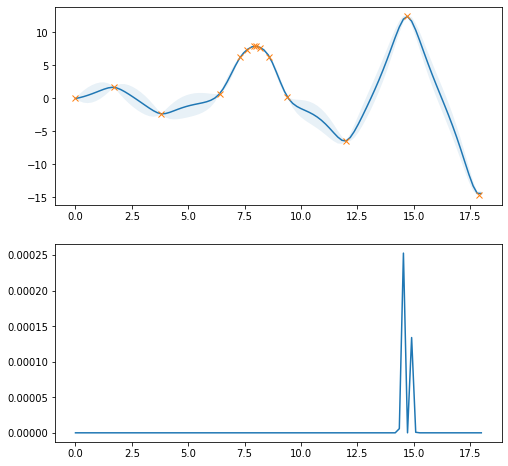

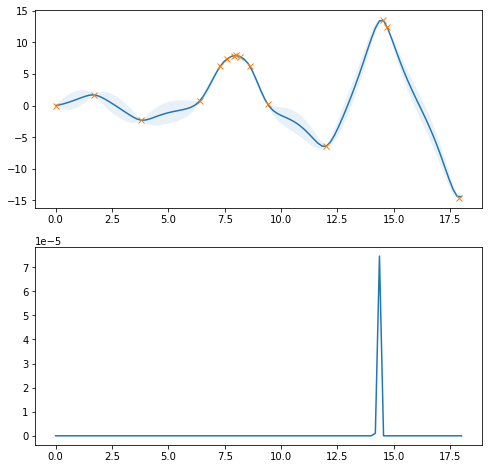

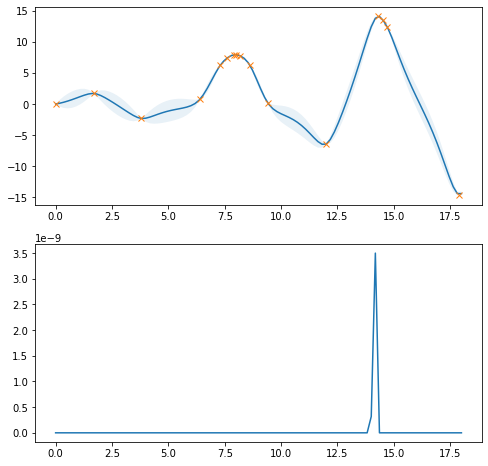

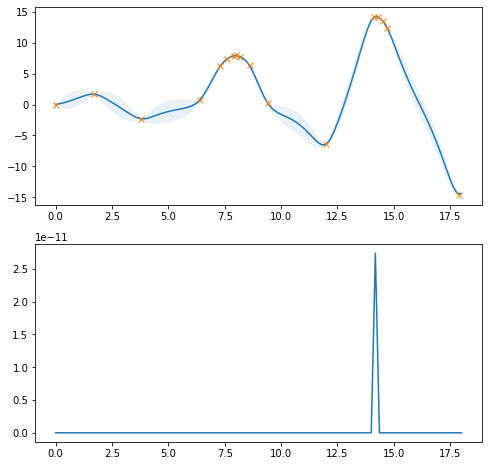

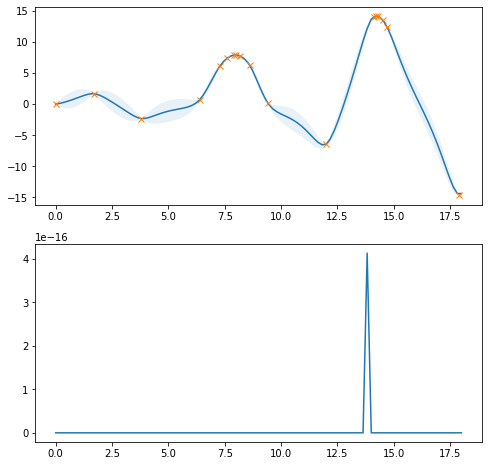

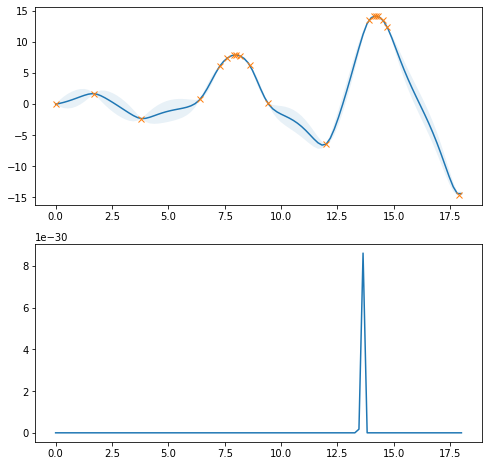

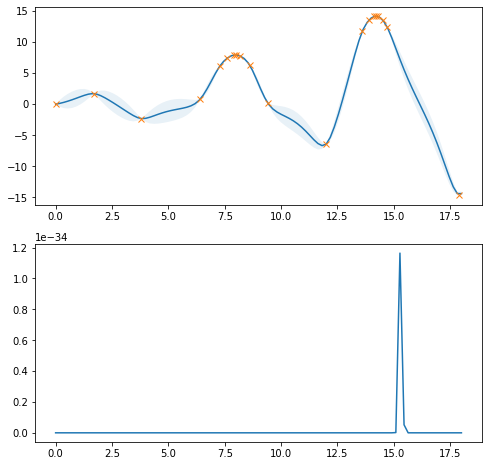

In [8]:
for i in range(20):
    view_acqfunc(i)

# use original kernel and acq function

In [9]:
dists = bayesopt.utils.pairwise(bayesopt.metric.euclid_distance,square=True)
def kernel(x,y):
    return np.exp(-dists(x,y))
print(kernel(np.array([[2,3],[1,2]]),np.array([[2,3],[1,2],[1,1]])))

[[1.         0.13533528 0.00673795]
 [0.13533528 1.         0.36787944]]


In [10]:
def acq(mu,sigma,*args,**kwargs):
    '''
    mu, sigma, it=it, vmax=vmax, vmin=vminが入力されるようacq optimで決めている.
    '''
    it = kwargs.get('it',5.)
    return -mu+sigma*5*np.sqrt(np.log(it+1)/(it+1))

In [14]:
BO = bayesopt.BayesOpt(f=f,
                       initial_input=np.array([0.]),
                       kernel=bayesopt.kernel.MaternKernel(),
                       acq=acq,
                       acq_optim=bayesopt.acquisition_optimizer.Acquisition_L_BFGS_B_Optimizer(bounds=[0,15]))
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s, param:[11.03789905], value:-11.028013957755743, current best param:[11.1047104], current best_value:-11.038643626478052] 


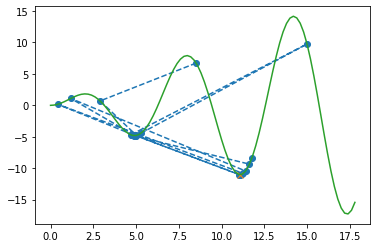

In [15]:
X = np.arange(0,18,0.2)
plt.plot(BO.param_history,BO.value_history,'o--')
plt.plot(BO.best_params,BO.best_value,'x')
plt.plot(X,f(X))

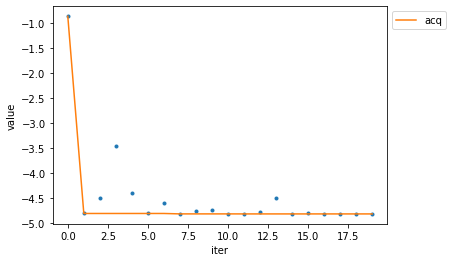

In [13]:
bayesopt.plot_history(BO)

# memo acuisition optimizer

In [11]:
def AcquisitionSLSQPOptimizer(gpr, acq, it, bounds, n_trial=5):
    ## gprとacqとitは受け取れるようにしないといけない. 
    ##boundsはfunctoolのpartialで指定するか、内部変数に持たせるか
    bounds = np.atleast_2d(bounds)
    vmax = np.max(gpr.Y_train)
    vmin = np.min(gpr.Y_train)
    ndim = len(bounds)
    loc = None
    value = None

    import scipy.optimize  
    def Obj(x):
        mu,sigma = gpr.posterior_predictive(np.atleast_2d(x),return_std=True)
        return -1.*acq(mu,sigma, it=it, vmax=vmax, vmin=vmin).ravel()

    x_seeds = onp.random.uniform(bounds[:,0],bounds[:,1], size=(n_trial,ndim)) 
    for xtry in x_seeds:
        res = scipy.optimize.fmin_slsqp(Obj, 
                                        x0=xtry, 
                                        bounds=bounds, 
                                        iprint=0, 
                                        full_output=True, 
                                        iter=100)
        if (loc is None) or (res[1] < value):
            loc = res[0]
            value = res[1]
    return loc, value

memo terminate functionを設定できるようにした   
入力はit,param_history,value_historyの順番で入る

In [12]:
def terminate_function(it, param_history, value_history):
    if value_history.min()<1e-1:
        return True
    else:
        return False